# NLST Raw Nifty, Sybil Annotations visualization in 3D 

With the [National Lung Screening Trial (NLST)](https://www.nejm.org/doi/full/10.1056/NEJMoa1208962), for detection evaluation, we utilized open-access annotations provided by [Mikhael et al.(2023)](https://doi.org/10.1200/JCO.22.01345). We converted over 9,000 2D slice-level bounding box annotations from more than 900 lung cancer patients into 3D representations, resulting in over 1,100 nodule annotations.


* Mikhael, Peter G., et al. "Sybil: a validated deep learning model to predict future lung cancer risk from a single low-dose chest computed tomography." Journal of Clinical Oncology 41.12 (2023): 2191-2200.

* National Lung Screening Trial Research Team. "Results of initial low-dose computed tomographic screening for lung cancer." New England Journal of Medicine 368.21 (2013): 1980-1991.

* Tushar, Fakrul Islam, et al. "AI in Lung Health: Benchmarking Detection and Diagnostic Models Across Multiple CT Scan Datasets." arXiv preprint arXiv:2405.04605 (2024).












|------------------------------ No=1 ------------------------------|


Loading the Image:1.2.840.113654.2.55.100267029693057843237393396736558778216
Number of Annotation:1


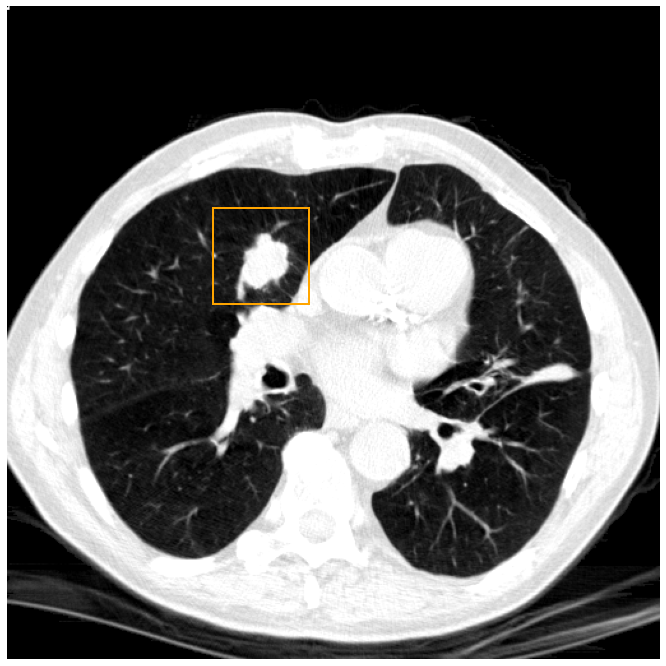

In [1]:
#-| Import libraries

import cv2
import numpy as np
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math 
import pandas as pd
import ast

##################################---Functions-------------#######################

def make_bold(text):
    return f"\033[1m{text}\033[0m"



#-| this function load an image using simpleITK and return 
#-|3D array, origin_numpy and spacing numpy
def load_itk_image(filename):
    '''
    this function load an image using simpleITK and return
    3D array, origin_numpy and spacing numpy
    input:  filename     = nifty CT image path eg."./CT_CTGRAV_TMP404180_4.nii.gz"
    output: numpyImage   = 3D CT numpy as slice X height x Width (z,y,x)
            numpyOrigin  = (z_origin,  y_origin,  x_origin)
            numpySpacing = (z_Spacing, y_Spacing, x_Spacing)
    '''
    itkimage = sitk.ReadImage(filename)           # load the ct image
    numpyImage = sitk.GetArrayFromImage(itkimage) # give CT to 3D numpy (z,y,x)
   
    #- When we load get the  itkimage.GetOrigin/GetSpacing it 
    # returns the array in order (x_origin, y_origin,z_origin)
    # as we loaded the CT image as 3D numpy (z,y,x) that is why
    # we also reversed the acquired spacing and origin
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))   # 3D numpy (z_origin,  y_origin,  x_origin)
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing()))) # 3D numpy (z_Spacing, y_Spacing, x_Spacing)
    return numpyImage, numpyOrigin, numpySpacing,itkimage


#-| this function will convert the world coordinate to the voxel coordinate
 #-|to visualize or acquired the bounding boxex on the 3D CT 
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

#-- Normalizing image for better visualization
def normalize_image_to_uint8(image, lower_bound=-1000, upper_bound=100.0):
    """
    Clip the image to the lung window, then normalize it to uint8.
    Args:
        image: numpy array
        lower_bound: lower HU bound for the lung window (default: -1500 HU)
        upper_bound: upper HU bound for the lung window (default: -500 HU)
    """
    # Clip to lung window
    clipped_img = np.clip(image, lower_bound, upper_bound)
    
    # Normalize to [0, 255]
    normalized_img = ((clipped_img - lower_bound) / (upper_bound - lower_bound)) * 255.0
    normalized_img = normalized_img.astype(np.uint8)
    
    return normalized_img

def is_number_in_range(number, start, end):
    """
    Check if the number is within the range [start, end] (inclusive).
    
    Args:
    number (int/float): The number to check.
    start (int/float): The start of the range.
    end (int/float): The end of the range.
    
    Returns:
    bool: True if the number is within the range, False otherwise.
    """
    return start <= number <= end



#-| A sample Jeson file dectionaly with coordinates
"""
The "data_sample.json" file is an example with X/Y/Z-axial center coordinates and box lengths (box mode cccwhd).
example_dictionary keys:
1. "label" = dummy Label as we don't have the ground truth
2. "box"   = Detected nodule Coordinates[x_center,y_center,z_Center,x_width,y_width,z_width] in world coordinate systems
3. "score" = probability for being a nodule
"""
#--------------- Reading json file--------------#

import json
  
# Opening JSON file
annotation_df = pd.read_csv('annotations/fitetal_NLST_3D_Annotation_worldxyzwh_CenterCordxyz.csv')
raw_data_path = 'data_dir/'
  
# returns JSON object as 
# a dictionary
Final_dect = annotation_df['seriesuid'].unique()[0:1]


for dictonary_list_i in range(0,len(Final_dect)):
    #print('|------------------------ No={} ---------------------|'.format(dictonary_list_i))
    print(make_bold('|' + '-'*30 + ' No={} '.format(dictonary_list_i+1) + '-'*30 + '|'))
    print('\n')
    
    desired_value      = Final_dect[dictonary_list_i] 
    filtered_df        = annotation_df[annotation_df['seriesuid'] == desired_value]
    example_dictionary = filtered_df.reset_index()
    
    # load image
    print('Loading the Image:{}'.format(example_dictionary['seriesuid'][0]))
    print('Number of Annotation:{}'.format(len(example_dictionary)))
    image_path =raw_data_path+example_dictionary['seriesuid'][0]+'.nii.gz'
    numpyImage, numpyOrigin, numpySpacing,itkimage = load_itk_image(filename=image_path)

    for Which_box_to_use in range(0,len(example_dictionary)):

        #--- Getting the box coordinate 
        world_x         =  example_dictionary["coordX"][Which_box_to_use]
        world_y         =  example_dictionary["coordY"][Which_box_to_use]       
        world_z         =  example_dictionary["coordZ"][Which_box_to_use]
        world_w         =  example_dictionary["diameter_mm"][Which_box_to_use]
        world_h         =  example_dictionary["diameter_mm"][Which_box_to_use]
  
                                 
        # Converting World coordinate to Image coordinate
        numbers_list   = [world_x,world_y,world_z]
        floats_list    = [float(num) for num in numbers_list]
        index          = itkimage.TransformPhysicalPointToIndex(floats_list)
        spacing        = itkimage.GetSpacing()
        w              = int(world_w / spacing[0])
        h              = int(world_h / spacing[1])
        x              = index[1] -int(w/2)
        y              = index[0] -int(h/2)
        
        plt.figure(figsize=(12,12))
        draw_img       = normalize_image_to_uint8(numpyImage[index[2],:,:],lower_bound=-1000, upper_bound=50)
        plt.imshow(draw_img, cmap='gray')
        plt.axis('off')
        plt.gca().add_patch(plt.Rectangle((x, y), int(w), int(h), fill=False, edgecolor='orange', linewidth=2))
        
    plt.axis('off')
    plt.show()

            
  

